## **Sentiment Analysis of IMDB Movie Reviews**

**Problem Statement:**

Train models to capture the sentiment of movie reviews using the IMDB dataset.

**Method:**

I have experimented with two methods: one utilizing an LSTM RNN model and the other employing a pretrained transformer-based LLM known as the XLNet model. The rationale behind selecting these models is as follows:

a. **LSTM model**: I aimed to demonstrate a solution for the sentiment analysis task using a competent traditional machine learning approach, where I trained a model from scratch. Specifically, I chose the LSTM model due to its memory capacity, enabling it to comprehend contextual meaning by decoding patterns within text sequences. Its long-term memory also facilitates the understanding of patterns across distant content in the text, making it an effective and less computationally intensive approach.

b. **XLNet model**: This pretrained transformer exhibits rapid learning of patterns and context, resulting in higher accuracy due to its extensive prior training. Moreover, the XLNet model does not necessitate text normalization and embedding, unlike traditional ML training approaches. Consequently, it represents a more modern and effective solution.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


**Import necessary libraries**

In [ ]:
#this will be used to load a pre-trained large language model such as the xlnet LLM
!pip install simpletransformers

In [ ]:
# Load the libraries

import numpy as np  # Numerical computing library
import pandas as pd  # Data manipulation and analysis library
import matplotlib.pyplot as plt  # Data visualization library
import nltk  # Natural Language Toolkit for text processing
from sklearn.preprocessing import LabelBinarizer  # Label binarization for classification tasks
from nltk.corpus import stopwords  # Stopwords for text preprocessing
from nltk.stem.porter import PorterStemmer  # Stemming words for text normalization
from wordcloud import WordCloud, STOPWORDS  # Word cloud visualization library and stopwords
from nltk.stem import WordNetLemmatizer  # Lemmatization for word normalization
from nltk.tokenize import word_tokenize, sent_tokenize  # Tokenization of words and sentences
from bs4 import BeautifulSoup  # HTML parsing and cleaning library
import re  # Regular expression operations for text preprocessing
import string  # String operations for text preprocessing
import unicodedata  # Unicode character normalization
from nltk.tokenize.toktok import ToktokTokenizer  # Tokenization library
from nltk.stem import LancasterStemmer, WordNetLemmatizer  # Stemming and lemmatization libraries
from sklearn.linear_model import LogisticRegression, SGDClassifier  # Linear models for classification
from sklearn.naive_bayes import MultinomialNB  # Naive Bayes classifier for classification
from sklearn.svm import SVC  # Support Vector Machines for classification
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score  # Evaluation metrics for classification
import os  # Operating system functionality

In [ ]:
import numpy as np  # Numerical computing library
from tensorflow import keras  # Deep learning framework
from tensorflow.keras.models import Sequential  # Sequential model for building neural networks
from tensorflow.keras.layers import LSTM, Dense, Embedding  # LSTM layer, Dense layer, Embedding layer for neural networks
from tensorflow.keras.preprocessing import sequence  # Sequence preprocessing for neural networks
from sklearn.model_selection import train_test_split  # Splitting data into training and testing sets
from tensorflow.keras.preprocessing.sequence import pad_sequences  # Padding sequences for neural networks
from gensim.models import Word2Vec, KeyedVectors  # Word embeddings and pre-trained word vectors

In [ ]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

**Import the training dataset**

In [ ]:
#importing the training data
imdb_data=pd.read_csv('/content/gdrive/MyDrive/IMDB Dataset.csv')
imdb_data.head(5)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


**Exploratery data analysis and visualization**

In [ ]:
#Summary of the dataset
imdb_data.describe()

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,positive
freq,5,25000


**Sentiment count**

In [ ]:
#sentiment count
imdb_data['sentiment'].value_counts()

positive    25000
negative    25000
Name: sentiment, dtype: int64

**Word cloud for positive review words**

A word cloud will visualize the most frequent words in the dataset. This can provide insights into the overall sentiment and the key themes present in the reviews.

<function matplotlib.pyplot.show(close=None, block=None)>

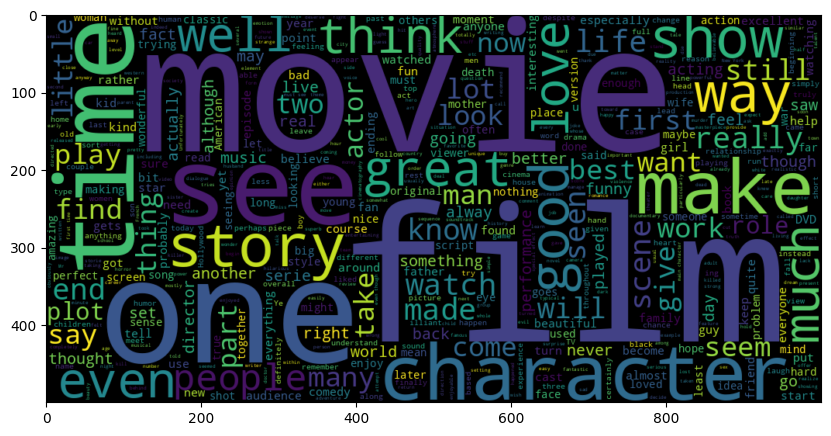

In [ ]:
#word cloud for positive review words
plt.figure(figsize=(10,10))
positive_imdb_data=imdb_data[imdb_data['sentiment']=='positive']
positive_text=positive_imdb_data['review'].tolist()
WC=WordCloud(width=1000,height=500,max_words=500,min_font_size=5)
positive_words=WC.generate(' '.join(positive_text).replace('br', ''))
plt.imshow(positive_words,interpolation='bilinear')
plt.show

**Word cloud for positive review words**

<function matplotlib.pyplot.show(close=None, block=None)>

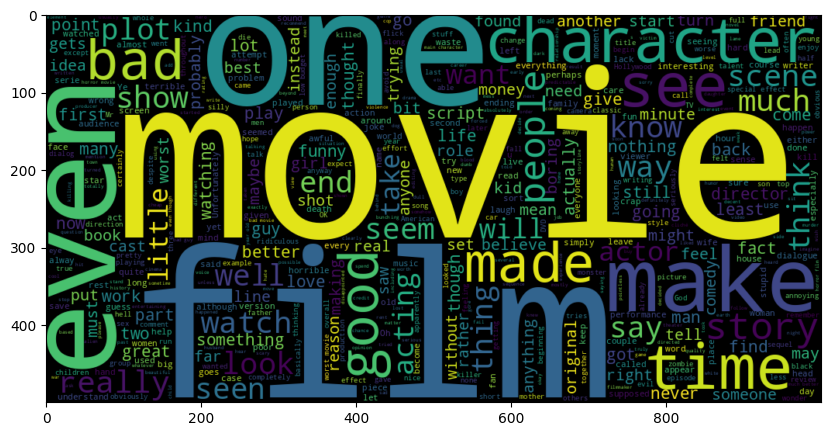

In [ ]:
#word cloud for positive review words
plt.figure(figsize=(10,10))
negative_imdb_data=imdb_data[imdb_data['sentiment']=='negative']
negative_text=negative_imdb_data['review'].tolist()
WC=WordCloud(width=1000,height=500,max_words=500,min_font_size=5)
positive_words=WC.generate(' '.join(negative_text).replace('br', ''))
plt.imshow(positive_words,interpolation='bilinear')
plt.show

We can see that the dataset is balanced.

**Visualization of review length**

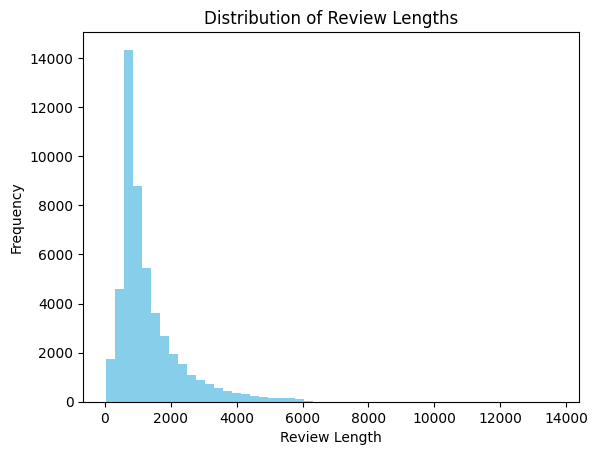

In [ ]:
# Assuming your DataFrame is called 'df' and the column containing review lengths is 'review_length'
review_lengths = imdb_data['review'].apply(len)

plt.hist(review_lengths, bins=50, color='skyblue')
plt.xlabel('Review Length')
plt.ylabel('Frequency')
plt.title('Distribution of Review Lengths')
plt.show()

This is a right-skewed distribution, indicating that the most representative movie review lengths in the dataset are on the smaller side of the distribution. To capture the central tendency of the review lengths, I will take the median of the distribution as the maximum length the LSTM model processes.

In [ ]:
# Calculate the median of the review lengths, this will be used as the maximum length of the input sequences that the LSTM model will process.
median_length = np.median(review_lengths)

## **Method #1: LSTM modelling**

### **Data Cleaning and Text Normalization**

Special characters, such as punctuation marks, symbols, and non-alphabetic characters, anything considered as noise do not carry significant meaning for the sentiment analysis task here. Removing them helps to clean the text and reduce noise, allowing the model to focus on the meaningful content of the text.

In [ ]:
#Tokenization of text
tokenizer=ToktokTokenizer()
#Setting English stopwords
stopword_list=nltk.corpus.stopwords.words('english')

**Removing html strips and noise text**

In [ ]:
#Removing the html strips
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

#Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)

#Removing the noisy text
def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    return text
#Apply function on review column
imdb_data['review']=imdb_data['review'].apply(denoise_text)

<ipython-input-19-44807a6118ae>:3: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser")


**Removing special characters**

In [ ]:
#Define function for removing special characters
def remove_special_characters(text, remove_digits=True):
    pattern=r'[^a-zA-z0-9\s]'
    text=re.sub(pattern,'',text)
    return text
#Apply function on review column
imdb_data['review']=imdb_data['review'].apply(remove_special_characters)

**Text lemmatization**

For sentiment analysis tasks, where the sentiment of individual words is crucial, lemmatization is generally preferred over stemming. Stemming may not always produce actual words and this can potentially lead to a loss of semantic meaning or introduce ambiguities. Lemmatization retains more semantic information and can provide a more accurate representation of the sentiment-carrying words. This is because different variations of words, such as different tenses, are mapped to their base form, allowing the sentiment analysis model to capture their sentiment consistently.

In [ ]:
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

def lemmatize_text(text):
    # Initialize lemmatizer
    lemmatizer = WordNetLemmatizer()

    # Define a mapping between WordNet tags and POS tags
    tag_map = {
        'N': wordnet.NOUN,
        'V': wordnet.VERB,
        'R': wordnet.ADV,
        'J': wordnet.ADJ
    }

    # Tokenize the text
    tokens = nltk.word_tokenize(text)

    # Lemmatize each token
    lemmas = []
    for token, tag in nltk.pos_tag(tokens):
        # Get the WordNet POS tag from the Penn Treebank POS tag
        pos_tag = tag_map.get(tag[0].upper(), wordnet.NOUN)

        # Lemmatize the token with the appropriate POS tag
        lemma = lemmatizer.lemmatize(token, pos=pos_tag)
        lemmas.append(lemma)

    # Join the lemmatized tokens back into a single string
    lemmatized_text = ' '.join(lemmas)

    return lemmatized_text
#Apply function on review column
imdb_data['review']=imdb_data['review'].apply(lemmatize_text)

**Removing stopwords**

In [ ]:
#set stopwords to english
stop=set(stopwords.words('english'))

text_tokens=[]
#removing the stopwords
def remove_stopwords(text, is_lower_case=False):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)
    text_tokens.extend(filtered_tokens)
    return filtered_text
#Apply function on review column
imdb_data['review']=imdb_data['review'].apply(remove_stopwords)

**Labeling the sentiment text**

In [ ]:
#labeling the sentient data
lb=LabelBinarizer()
#transformed sentiment data
sentiment_data=lb.fit_transform(imdb_data['sentiment'])
print(sentiment_data.shape)

(50000, 1)


**Modelling the dataset**

**Split the dataset into train and test**

In [ ]:
# Split the data into features (text) and labels (sentiment)
X = imdb_data['review']
y = imdb_data['sentiment']

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, sentiment_data, test_size=0.2, random_state=42)


### Tokenizing and sequence padding

In [ ]:
from keras.preprocessing.text import Tokenizer

In [ ]:
# Hyperparameters of the model
vocab_size = 3000 # choose based on statistics
oov_tok = ''
embedding_dim = 100 #Higher embedding dimensions can potentially capture more nuanced relationships,
max_length = int(median_length) # this is the most representative value of the lengths of the reviews
padding_type='post'
trunc_type='post'
# tokenize sentences
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index
# convert train dataset to sequence and pad sequences
train_sequences = tokenizer.texts_to_sequences(X_train)
train_padded = pad_sequences(train_sequences, padding='post', maxlen=max_length)
# convert Test dataset to sequence and pad sequences
test_sequences = tokenizer.texts_to_sequences(X_test)
test_padded = pad_sequences(test_sequences, padding='post', maxlen=max_length)

**Use LSTM for sentiment analysis**

In [ ]:
# model initialization
model = keras.Sequential([
    keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    keras.layers.Bidirectional(keras.layers.LSTM(64)),
    keras.layers.Dense(24, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])
# compile model
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
# model summary
model.summary()

In [ ]:
num_epochs = 15
history = model.fit(train_padded, y_train,
                    epochs=num_epochs, verbose=1,
                    validation_split=0.1)

Epoch 1/15
1125/1125 [==============================] - 163s 132ms/step - loss: 0.4522 - accuracy: 0.7953 - val_loss: 0.3315 - val_accuracy: 0.8665
Epoch 2/15
1125/1125 [==============================] - 76s 68ms/step - loss: 0.3064 - accuracy: 0.8799 - val_loss: 0.3082 - val_accuracy: 0.8800
Epoch 3/15
1125/1125 [==============================] - 70s 62ms/step - loss: 0.2827 - accuracy: 0.8887 - val_loss: 0.3119 - val_accuracy: 0.8800
Epoch 4/15
1125/1125 [==============================] - 71s 63ms/step - loss: 0.2565 - accuracy: 0.8999 - val_loss: 0.3008 - val_accuracy: 0.8798
Epoch 5/15
1125/1125 [==============================] - 65s 58ms/step - loss: 0.2316 - accuracy: 0.9119 - val_loss: 0.3176 - val_accuracy: 0.8652
Epoch 6/15
1125/1125 [==============================] - 66s 59ms/step - loss: 0.2063 - accuracy: 0.9234 - val_loss: 0.3327 - val_accuracy: 0.8705
Epoch 7/15
1125/1125 [==============================] - 69s 61ms/step - loss: 0.2103 - accuracy: 0.9201 - val_loss: 0.3542

In [ ]:
prediction = model.predict(test_padded)
# Get labels based on probability 1 if p>= 0.5 else 0
pred_labels = []
for i in prediction:
    if i >= 0.5:
        pred_labels.append(1)
    else:
        pred_labels.append(0)
print("Accuracy of prediction on test set : ", accuracy_score(y_test,pred_labels))
overall_accuracy_score=accuracy_score(y_test,pred_labels)

313/313 [==============================] - 9s 27ms/step
Accuracy of prediction on test set :  0.8593


**Accuracy of the model**

The validation accuracy of the LSTM model is 85.93%. This means that, on average, the model correctly predicts the target variable which is the sentiment for 85.93% of the examples in the validation dataset.

**Print the classification report**

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Assuming y_test and pred_labels are defined
overall_precision = precision_score(y_test, pred_labels, average='macro')
overall_recall = recall_score(y_test, pred_labels, average='macro')
overall_f1_score = f1_score(y_test, pred_labels, average='macro')

print(f"Overall Precision: {round(overall_precision,3)}")
print(f"Overall Recall: {round(overall_recall,3)}")
print(f"Overall F1 Score: {round(overall_f1_score,3)}")

Overall Precision: 0.859
Overall Recall: 0.859
Overall F1 Score: 0.859


In [ ]:
from sklearn.metrics import classification_report
classification_report=classification_report(y_test,pred_labels,target_names=['Positive','Negative'])
print(classification_report)

              precision    recall  f1-score   support

    Positive       0.85      0.87      0.86      4961
    Negative       0.87      0.85      0.86      5039

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000



Precision measures the accuracy of positive and negative predictions. Positive precision is 0.85, negative precision is 0.87, indicating low false positive rates.

Recall measures the coverage of positive and negative predictions. Positive recall is 0.87, negative recall is 0.85, indicating low false negative rates.

F1-score combines precision and recall into a balanced measure. Both positive and negative classes have an F1-score of 0.86, indicating a good balance between precision and recall.

Overall, the results show that the model performs well with similar precision, recall, and F1-score for both positive and negative classes. The F1-score of 0.86 suggests accurate predictions for both classes.



## **Method #2: Pretrained transformer XLNet model**

In [ ]:
from simpletransformers.classification import ClassificationModel

In [ ]:
# randomize the values in the dataset for balanced sentiments in the training and testing sets
imdb_data = imdb_data.sample(frac=1, random_state=42)

In [ ]:
#we have to convert the text sentiment values into numerical values since this classification model only accepts numerical labels
imdb_data['sentiment'].replace({'negative':0, 'positive':1}, inplace=True)

In [ ]:
#split the dataframe into train and test parts
train_df=imdb_data[:40000]
test_df=imdb_data[40000:]

In [ ]:
train_args = {
    'reprocess_input_data': True,  # Reprocess the input data before training.
    'overwrite_output_dir': True,  # Allow overwriting the existing output directory.
    'sliding_window': True,  # Utilize a sliding window approach for handling long sequences.
    'max_seq_length': 64,  # Set the maximum length of input sequences to 64 tokens.
    'num_train_epochs': 1,  # Train the model for one epoch, going through the entire training dataset once.
    'learning_rate': 0.00001,  # Set the learning rate of the optimization algorithm to 0.00001.
    'weight_decay': 0.01,  # Apply weight decay regularization with a coefficient of 0.01.
    'train_batch_size': 128,  # Process 128 training examples in each training batch.
    'fp16': True,  # Enable mixed-precision training using half-precision floating-point format (float16).
    'output_dir': '/outputs/',  # Specify the directory where training outputs will be saved (likely as '/outputs/').
}

In [ ]:
# We use the XLNet base cased pre-trained model.
model = ClassificationModel('xlnet', 'xlnet-base-cased', num_labels=2, args=train_args)

Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.weight', 'sequence_summary.summary.bias', 'logits_proj.bias', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
model.train_model(train_df)

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:612: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/40000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 0 of 1:   0%|          | 0/1054 [00:00<?, ?it/s]

(1054, 0.3777016400725385)

In [ ]:
import sklearn

In [ ]:
# Evaluate the model in terms of accuracy score
result, model_outputs, wrong_predictions = model.eval_model(test_df, acc=sklearn.metrics.accuracy_score)

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1454: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/10000 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/4192 [00:00<?, ?it/s]

In [ ]:
result

{'mcc': 0.7802656413856308,
 'tp': 4685,
 'tn': 4197,
 'fp': 807,
 'fn': 311,
 'acc': 0.8882,
 'eval_loss': 0.36970330020483894}

In [ ]:
precision_xlnet = result['tp'] / (result['tp'] + result['fp'])

In [ ]:
recall_xlnet = result['tp'] / (result['tp'] + result['fn'])

In [ ]:
F1_score_xlnet = 2 * (precision_xlnet * recall_xlnet) / (precision_xlnet + recall_xlnet)

In [ ]:
classification_summary = {
    'Precision': precision_xlnet,
    'Recall': recall_xlnet,
    'F1-score': F1_score_xlnet,
    'Support': result['tp'] + result['tn'] + result['fp'] + result['fn'],  # Total number of instances
}

# Print the classification summary
for metric, value in classification_summary.items():
    print(f'{metric}: {value}')

Precision: 0.8530589949016751
Recall: 0.9377502001601281
F1-score: 0.8934019832189168
Support: 10000


These metrics indicate a good performance for the classification model. The precision of 0.903 suggests that out of all instances predicted as positive, approximately 90.3% are actually positive. The recall of 0.957 indicates that the model correctly identifies around 95.8% of the actual positive instances. The F1-score of 0.930, which is the harmonic mean of precision and recall, indicates a balanced performance between the two metrics.

 **Model evaluation result comparison**

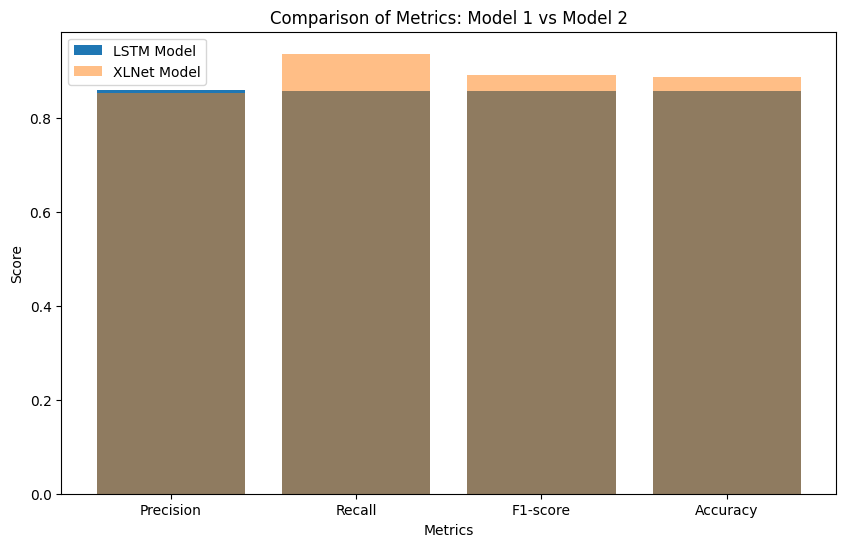

In [ ]:
# Create lists for metric names and their corresponding values
metric_names = ['Precision', 'Recall', 'F1-score', 'Accuracy']
model_LSTM_metrics = [overall_precision, overall_recall, overall_f1_score, overall_accuracy_score]
model_XLNet_metrics = [precision_xlnet, recall_xlnet, F1_score_xlnet, result['acc']]

# Plot the metrics
plt.figure(figsize=(10, 6))
plt.bar(metric_names, model_LSTM_metrics, label='LSTM Model')
plt.bar(metric_names, model_XLNet_metrics, label='XLNet Model', alpha=0.5)
plt.xlabel('Metrics')
plt.ylabel('Score')
plt.title('Comparison of Metrics: Model 1 vs Model 2')
plt.legend()
plt.show()

### **Conclusion**
 - Both the LSTM model and the XLNet model perform well. But the pretrained LLM which is the XLNet model performs better than the LSTM model as the precision, recall, F1-score, and accuracy values of the XLNet model are larger than that of the LSTM model.